In [1]:
# === 1. Game State Logic ===
from copy import deepcopy
import pandas as pd
from collections import Counter

NUM_ROWS = 6
NUM_COLS = 7

class State:
    def __init__(self):
        self.board = [[0]*NUM_COLS for _ in range(NUM_ROWS)]
        self.column_heights = [NUM_ROWS - 1] * NUM_COLS
        self.available_moves = list(range(7))
        self.player = 1
        self.winner = -1

    def check_line(self, n, player, values):
        num_pieces = sum(val == player for val in values)
        if n == 4:
            return num_pieces == 4
        if n == 3:
            return num_pieces == 3 and values.count(0) == 1

    def count_lines(self, n, player):
        num_lines = 0
        for row in range(NUM_ROWS):
            for col in range(NUM_COLS):
                if col < NUM_COLS - 3 and self.check_line(n, player, [self.board[row][col+i] for i in range(4)]):
                    num_lines += 1
                if row < NUM_ROWS - 3 and self.check_line(n, player, [self.board[row+i][col] for i in range(4)]):
                    num_lines += 1
                if row < NUM_ROWS - 3 and col < NUM_COLS - 3 and self.check_line(n, player, [self.board[row+i][col+i] for i in range(4)]):
                    num_lines += 1
                if row < NUM_ROWS - 3 and col > 2 and self.check_line(n, player, [self.board[row+i][col-i] for i in range(4)]):
                    num_lines += 1
        return num_lines

    def central(self, player):
        points = 0
        for row in range(NUM_ROWS):
            if self.board[row][4] == player:
                points += 2
            if self.board[row][3] == player or self.board[row][5] == player:
                points += 1
        return points

    def move(self, column):
        state_copy = deepcopy(self)
        height = state_copy.column_heights[column]
        state_copy.board[height][column] = self.player
        if height == 0:
            state_copy.available_moves.remove(column)
        else:
            state_copy.column_heights[column] = height - 1
        state_copy.update_winner()
        state_copy.player = 3 - self.player
        return state_copy

    def update_winner(self):
        if self.count_lines(4, 1) > 0:
            self.winner = 1
        elif self.count_lines(4, 2) > 0:
            self.winner = 2
        elif not self.available_moves:
            self.winner = 0

In [2]:
# === 2. Game Interface ===
def display_board(board):
    print("\n  1 2 3 4 5 6 7")
    print(" ---------------")
    for row in board:
        print("|", end="")
        for cell in row:
            print(" ".join("X" if cell == 1 else "O" if cell == 2 else " "), end="|")
        print()
    print(" ---------------")

def print_welcome():
    print("\n===== CONNECT 4 =====")
    print("1. Player vs Player")
    print("2. Player vs Computer")
    print("3. Computer vs Computer")
    print("4. Exit")
    print("====================")



In [ ]:
import os
import pandas as pd
import numpy as np
import math
from collections import Counter

# === 6. Learning from Logs ===

class DecisionNode:
    def __init__(self, feature=None, children=None, label=None):
        self.feature = feature
        self.children = children if children is not None else {}
        self.label = label

    def is_leaf(self):
        return self.label is not None

class ID3DecisionTree:
    def __init__(self):
        self.tree = None

    def fit(self, X: pd.DataFrame, y: pd.Series, max_depth=None):
        data = X.copy()
        data['label'] = y
        self.tree = self._id3(data, X.columns, depth=0, max_depth=max_depth)

    def _entropy(self, labels):
        counts = Counter(labels)
        total = len(labels)
        entropy = 0
        for count in counts.values():
            probability = count / total
            entropy -= probability * math.log2(probability)
        return entropy

    def _information_gain(self, data, feature, target_attribute='label'):
        total_entropy = self._entropy(data[target_attribute])
        values = data[feature].unique()
        weighted_entropy = 0
        for value in values:
            subset = data[data[feature] == value]
            weighted_entropy += (len(subset) / len(data)) * self._entropy(subset[target_attribute])
        return total_entropy - weighted_entropy

    def _id3(self, data, features, depth=0, max_depth=None):
        labels = data['label']
        if len(set(labels)) == 1:
            return DecisionNode(label=labels.iloc[0])
        if len(features) == 0 or (max_depth is not None and depth >= max_depth):
            return DecisionNode(label=labels.mode()[0])

        gains = [(feature, self._information_gain(data, feature)) for feature in features]
        best_feature, _ = max(gains, key=lambda item: item[1])
        node = DecisionNode(feature=best_feature)

        for value in data[best_feature].unique():
            subset = data[data[best_feature] == value]
            if subset.empty:
                node.children[value] = DecisionNode(label=labels.mode()[0])
            else:
                remaining_features = features.drop(best_feature)
                node.children[value] = self._id3(subset, remaining_features, depth + 1, max_depth)
        return node

    def predict_one(self, example, node=None):
        if node is None:
            node = self.tree
        if node.is_leaf():
            return node.label
        feature_value = example[node.feature]
        child = node.children.get(feature_value)
        if child is None:
            return None
        return self.predict_one(example, child)

    def predict(self, X: pd.DataFrame):
        return X.apply(lambda row: self.predict_one(row), axis=1)


# === Treinamento inicial seguro ===
learned_tree = ID3DecisionTree()

try:
    match_data = pd.read_csv("match_log.csv")
    match_data = match_data[match_data['winner'] != -1]

    # Remove estados duplicados com mesmo jogador
    match_data.drop_duplicates(subset=[f'cell_{i}' for i in range(42)] + ['player'], inplace=True)


    # Embaralha e divide em treino/validação
    match_data = match_data.sample(frac=1, random_state=42).reset_index(drop=True)
    split_index = int(0.8 * len(match_data))
    train_data = match_data.iloc[:split_index]
    val_data = match_data.iloc[split_index:]

    X_train = train_data[[f'cell_{i}' for i in range(42)] + ['player']]
    y_train = train_data['winner']
    X_val = val_data[[f'cell_{i}' for i in range(42)] + ['player']]
    y_val = val_data['winner']

     # Verifica quantos estados aparecem tanto no treino quanto na validação
    overlap = pd.merge(X_train, X_val, how='inner')
    print(f"⚠️ Overlap entre treino e validação: {len(overlap)} exemplos idênticos")

    # Avaliação por profundidade
    def evaluate_accuracy(tree, X_val, y_val):
        preds = tree.predict(X_val).fillna(-1)  # Substitui None por -1
        return (preds == y_val).mean()

    best_tree = None
    best_acc = 0
    best_depth = 0

    for depth in range(1, 10):
        tree = ID3DecisionTree()
        tree.fit(X_train, y_train, max_depth=depth)
        acc = evaluate_accuracy(tree, X_val, y_val)
        print(f"Depth {depth}: Val Accuracy = {acc:.3f}")
        if acc > best_acc:
            best_acc = acc
            best_depth = depth
            best_tree = tree

    learned_tree = best_tree
    print(f"✅ Melhor profundidade: {best_depth} com acurácia de {best_acc:.3f}")

except FileNotFoundError:
    print("Nenhum log encontrado. IA será treinada após os primeiros jogos.")

# === Salvamento de logs ===
def save_match_log(game_history, winner, file_path="match_log.csv"):
    logs = []
    for state in game_history:
        flat_board = sum(state.board, [])
        entry = {f'cell_{i}': val for i, val in enumerate(flat_board)}
        entry['player'] = state.player
        entry['winner'] = winner
        logs.append(entry)
    
    df = pd.DataFrame(logs)

    header_needed = not os.path.exists(file_path) or os.stat(file_path).st_size == 0
    df.to_csv(file_path, mode='a', header=header_needed, index=False)


Nenhum log encontrado. IA será treinada após os primeiros jogos.


In [4]:
# === 3. Game Controller Class ===
import time

class ConnectFourGame:
    def __init__(self, player_1_ai, player_2_ai):
        self.state = State()
        self.player_1_ai = player_1_ai
        self.player_2_ai = player_2_ai
        self.match_log = []

    def record_state(self):
        flat_board = sum(self.state.board, [])
        state_record = {f'cell_{i}': val for i, val in enumerate(flat_board)}
        state_record['player'] = self.state.player
        state_record['winner'] = self.state.winner
        self.match_log.append(state_record)

    def save_match_log(self, filename="match_log.csv"):
        if self.match_log:
            print(f"Saving match log with {len(self.match_log)} entries.")
            df = pd.DataFrame(self.match_log)
            df.to_csv(filename, mode='a', header=not pd.io.common.file_exists(filename), index=False)
            self.match_log = []

    def start(self, log_moves=False):
        self.state = State()
        while self.state.winner == -1:
            self.record_state()
            if self.state.player == 1:
                self.player_1_ai(self)
            else:
                self.player_2_ai(self)
            if log_moves:
                display_board(self.state.board)
        self.record_state()
        self.save_match_log()
        if self.state.winner == 0:
            print("End of game! Draw!")
        else:
            print(f"End of game! Player {self.state.winner} wins!")

    def run_n_matches(self, n, max_time=3600, log_moves=False):
        start_time = time.time()
        results = [0, 0, 0]
        total_games = n  # Salva o total original

        while n > 0 and time.time() - start_time < max_time:
            n -= 1
            self.start(log_moves)
            results[self.state.winner] += 1

            # 🔍 Registro de desempenho
            game_number = total_games - n
            with open("performance_log.csv", "a") as f:
                f.write(f"{game_number},{self.state.winner}\n")

            # 🔄 Reentreinamento da IA
            try:
                match_data = pd.read_csv("match_log.csv")
                match_data = match_data[match_data['winner'] != -1]

                if match_data.empty:
                    print("⚠️ match_log.csv está vazio. Ignorando reentreinamento.")
                    continue

                match_data.drop_duplicates(subset=[f'cell_{i}' for i in range(42)] + ['player'], inplace=True)
                X = match_data[[f'cell_{i}' for i in range(42)] + ['player']]
                y = match_data['winner']

                if len(X) == 0 or y.nunique() < 2:
                    print("⚠️ Dados insuficientes para treinar. Pulando treino.")
                    continue

                global learned_tree
                learned_tree = ID3DecisionTree()
                learned_tree.fit(X, y, max_depth=3)

            except FileNotFoundError:
                print("⚠️ match_log.csv não encontrado. IA só será treinada após as primeiras partidas.")
                continue

        print("\n=== Elapsed time: %s seconds ===" % int(time.time() - start_time))
        print(f"  Player 1: {results[1]} victories")
        print(f"  Player 2: {results[2]} victories")
        print(f"  Draws: {results[0]}")
        print("===============================")




In [ ]:
# === 4. Human & AI Players Moves ===
import random
def human_player_move(game):
    while True:
        try:
            print(f"\nPlayer {game.state.player}'s turn")
            print(f"Available columns: {[col+1 for col in game.state.available_moves]}")
            column = int(input("Enter column number (1-7): ")) - 1
            if column in game.state.available_moves:
                game.state = game.state.move(column)
                break
            else:
                print("Invalid move! Try again.")
        except ValueError:
            print("Please enter a valid number.")

def execute_random_move(game):
    move = random.choice(game.state.available_moves)
    game.state = game.state.move(move)

def execute_smart_move(game):
    available_moves = game.state.available_moves
    current_player = game.state.player
    opponent = 3 - current_player

    for move in available_moves:
        new_state = game.state.move(move)
        if new_state.winner == current_player:
            game.state = new_state
            return

    for move in available_moves:
        test_state = game.state.move(move)
        test_state.player = opponent
        for opp_move in test_state.available_moves:
            if opp_move == move:
                continue
            potential_state = test_state.move(opp_move)
            if potential_state.winner == opponent:
                game.state = game.state.move(move)
                return

    best_move = None
    best_score = float('-inf')
    for move in available_moves:
        new_state = game.state.move(move)
        score = (new_state.count_lines(3, current_player) * 10 + 
                 new_state.central(current_player) * 2 - 
                 new_state.count_lines(3, opponent) * 8)
        if score > best_score:
            best_score = score
            best_move = move

    if best_move is None:
        for preferred in [3, 2, 4, 1, 5, 0, 6]:
            if preferred in available_moves:
                best_move = preferred
                break

    game.state = game.state.move(best_move)

    # === Execução da IA aprendida ===
def execute_learned_move(game):
    if learned_tree.tree is None:
        print("⚠️ Árvore de decisão ainda não foi treinada.")
        execute_random_move(game)
        return
    
    flat_board = sum(game.state.board, [])
    features = {f'cell_{i}': val for i, val in enumerate(flat_board)}
    features['player'] = game.state.player
    move_scores = {}
    for move in game.state.available_moves:
        next_state = game.state.move(move)
        flat_next = sum(next_state.board, [])
        sample = {f'cell_{i}': val for i, val in enumerate(flat_next)}
        sample['player'] = next_state.player
        pred = learned_tree.predict_one(sample)
        move_scores[move] = pred if pred is not None else 0
    best_move = max(move_scores, key=move_scores.get)
    game.state = game.state.move(best_move)

In [6]:
# === 5. Monte Carlo Tree Search ===
import math

class MCNode:
    def __init__(self, game, player):
        self.game = game
        self.visits = 1
        self.wins = 0
        self.children = []
        self.player = player

    def is_leaf(self):
        return len(self.children) == 0

    def add_child(self, player):
        if not self.game.state.available_moves:
            return self
        for move in self.game.state.available_moves:
            new_game = deepcopy(self.game)
            new_game.state = new_game.state.move(move)
            self.children.append(MCNode(new_game, player))
        return random.choice(self.children)

    def update_stats(self, value):
        if self.player == 1 and value == 2:
            value = 0
        elif self.player == 2 and value == 1:
            value = 0
        elif value == self.player:
            value = 1
        else:
            value = 0
        self.wins += value
        self.visits += 1

class MCTree:
    def __init__(self, root):
        self.root = root

    def expand(self, node, player_cur):
        return node.add_child(player_cur)

def monte_carlo(epochs, tree, c, player):
    for _ in range(epochs):
        visited = []
        player_cur = player
        node = tree.root
        visited.append(node)
        while not node.is_leaf():
            node = select(node, node.children, c, player_cur)
            visited.append(node)
            player_cur = 3 - player_cur
        new_child = tree.expand(node, player_cur)
        visited.append(new_child)
        value = roll_out(new_child)
        for node in visited:
            node.update_stats(value)
    return best_action(tree.root)

def select(node, children, c, player):
    best_value = -math.inf
    best_node = None
    for child in children:
        uct_value = (child.wins / child.visits) + c * math.sqrt(math.log(node.visits) / child.visits)
        if child.player != player:
            uct_value = -uct_value
        if uct_value > best_value:
            best_value = uct_value
            best_node = child
    return best_node

def best_action(root):
    return max(root.children, key=lambda child: child.wins / child.visits)

def roll_out(node):
    while node.game.state.winner == -1:
        execute_random_move(node.game)
    return node.game.state.winner

def execute_monte_carlo_move(epochs, c, player):
    def inner(game):
        root = MCNode(game, 3 - player)
        next_node = monte_carlo(epochs, MCTree(root), c, player)
        game.state = next_node.game.state
    return inner


In [7]:
# === 7. Main Game Loop ===

if __name__ == "__main__":
    while True:
        print_welcome()
        choice = input("Select game mode: ")

        if choice == "1":
            game = ConnectFourGame(human_player_move, human_player_move)
            game.start()
        elif choice == "2":
            player_choice = input("Play as Player 1 (X) or Player 2 (O)? (1/2): ")
            learned_ai = execute_learned_move
            game = ConnectFourGame(human_player_move, learned_ai) if player_choice == "1" else ConnectFourGame(learned_ai, human_player_move)
            game.start()

            # ← Reentreina após jogo
            match_data = pd.read_csv("match_log.csv")
            match_data = match_data[match_data['winner'] != -1]
            X = match_data[[f'cell_{i}' for i in range(42)] + ['player']]
            y = match_data['winner']
            learned_tree.fit(X, y)

        elif choice == "3":
            # game = ConnectFourGame(execute_learned_move, execute_monte_carlo_move(200, 1.14, 2))
            # game = ConnectFourGame(execute_monte_carlo_move(200, 1.14, 1), execute_monte_carlo_move(200, 1.14, 2))
            game = ConnectFourGame(execute_learned_move, execute_random_move)

            num_games = int(input("How many games to run? "))
            game.run_n_matches(num_games)

            # Recarrega e embaralha os dados
            import numpy as np
            match_data = pd.read_csv("match_log.csv")
            match_data = match_data[match_data['winner'] != -1]
            match_data = match_data.sample(frac=1, random_state=42).reset_index(drop=True)

            split_index = int(0.8 * len(match_data))
            train_data = match_data.iloc[:split_index]
            val_data = match_data.iloc[split_index:]

            X_train = train_data[[f'cell_{i}' for i in range(42)] + ['player']]
            y_train = train_data['winner']
            X_val = val_data[[f'cell_{i}' for i in range(42)] + ['player']]
            y_val = val_data['winner']

            # Avaliação com profundidades diferentes
            def evaluate_accuracy(tree, X_val, y_val):
                preds = tree.predict(X_val)
                return (preds == y_val).mean()

            best_tree = None
            best_acc = 0
            best_depth = 0

            for depth in range(1, 10):
                tree = ID3DecisionTree()
                tree.fit(X_train, y_train, max_depth=depth)
                acc = evaluate_accuracy(tree, X_val, y_val)
                print(f"Depth {depth}: Val Accuracy = {acc:.3f}")
                if acc > best_acc:
                    best_acc = acc
                    best_depth = depth
                    best_tree = tree

            learned_tree = best_tree
            print(f"✅ Melhor profundidade: {best_depth} com acurácia de {best_acc:.3f}")

        elif choice == "4":
            print("Thanks for playing!")
            break
        else:
            print("Invalid choice. Try again.")



===== CONNECT 4 =====
1. Player vs Player
2. Player vs Computer
3. Computer vs Computer
4. Exit


AttributeError: 'NoneType' object has no attribute 'is_leaf'

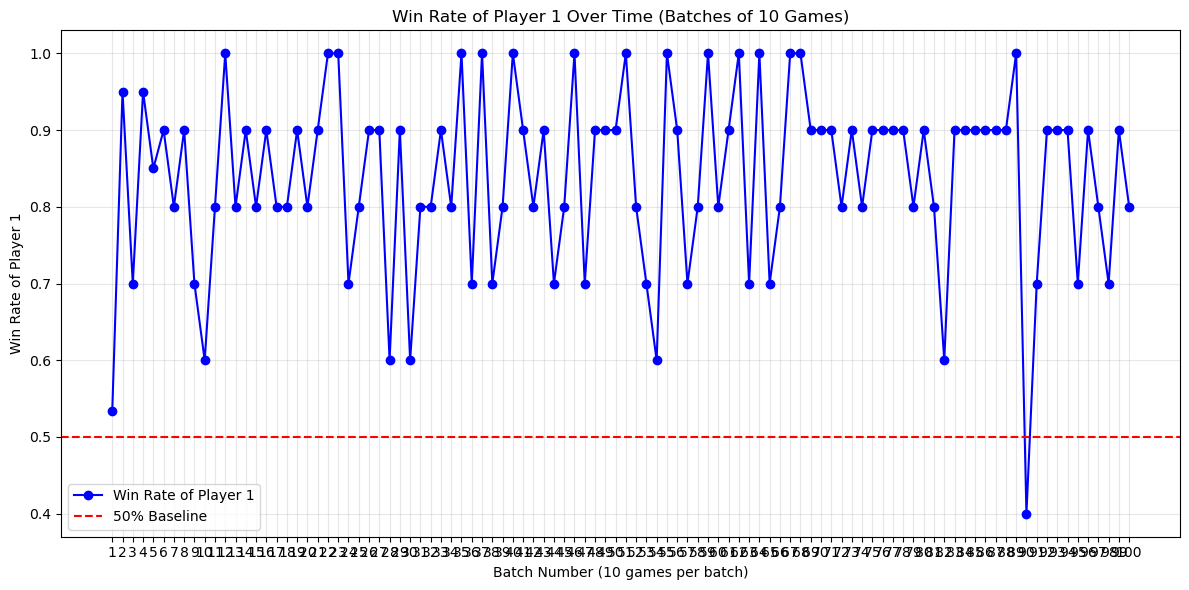

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import os

def analyze_performance(file_path='performance_log.csv', batch_size=50):
    if not os.path.exists(file_path):
        print(f"Arquivo {file_path} não encontrado.")
        return

    # Carregar dados
    data = pd.read_csv(file_path, header=None, names=['game', 'winner'])

    # Agrupar em batches de 'batch_size'
    data['batch'] = (data['game'] - 1) // batch_size

    # Calcular taxa de vitória por batch
    batch_stats = data.groupby('batch')['winner'].apply(lambda x: (x == 1).mean())

    # Plotar gráfico
    plt.figure(figsize=(12, 6))
    plt.plot(batch_stats.index + 1, batch_stats.values, marker='o', linestyle='-', color='blue', label='Win Rate of Player 1')
    plt.axhline(y=0.5, color='red', linestyle='--', label='50% Baseline')
    plt.xlabel('Batch Number (50 games per batch)')
    plt.ylabel('Win Rate of Player 1')
    plt.title('Win Rate of Player 1 Over Time (Batches of 10 Games)')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.xticks(range(1, len(batch_stats) + 1))
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    analyze_performance()
